# LSTM model
This notebook deals with training & testing an LSTM model for bitcoin price prediction. We'll use PyTorch and particularly PyTorch Lightning modules to build the network.

In [1]:
# import necessary libraries and read data
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning.metrics.functional import accuracy
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
# df = pd.read_csv('data/raw.csv').drop(columns='market_caps')

### Preprocessing & Setup
The LSTM takes data in the format `(batch_len, seq_len, n_features)`, so we'll do some data preprocessing to get it into that format (soon). In this case, the batch length is the number of labeled samples, and the sequence length is the number of timesteps per sample.

In [98]:
# splitting data at random into train/test sets, since we've fixed all the time-dependencies
class BTCData(pl.LightningDataModule):
    def __init__(self, filename, nrows=None):
        super().__init__()
        self.scaler = MinMaxScaler()
        self.filename = filename
        self.batch_size = 64
        self.nrows = nrows
        
    # load data from file
    def load_data(self):
        if self.nrows is not None:
            return np.load(self.filename)[:self.nrows]
        return np.load(self.filename)
    
    # create pytorch dataset from data
    def make_dataset(self, X, y):
        X = torch.Tensor(X)
        y = torch.Tensor(y).type(torch.LongTensor)
        
        return TensorDataset(X, y)
        
    def setup(self, stage):
        # load dataset, split into X and y, relabel y to {0, 1}
        dataset = self.load_data()
        X = dataset[:, :-1]
        y = dataset[:, -1]
        y[y == -1] = 0
                
        # transform data
        X = self.scaler.fit_transform(X)
                
        # group data into sequences
        self.seq_len = 60
        full_len = len(X) - self.seq_len
        self.n_features = 6
        X_sequenced = np.zeros((full_len, self.seq_len, self.n_features))
        for i in range(full_len):
            X_sequenced[i] = X[i:i + self.seq_len]
        y = y[self.seq_len:]
            
        # split into train, validate, and test datasets
        test_size = 0.2
        val_size = 0.125
        X_train, X_test, y_train, y_test = train_test_split(X_sequenced, y, test_size=test_size)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size)
        
        # create the datasets
        self.train = self.make_dataset(X_train, y_train)
        self.val = self.make_dataset(X_val, y_val)
        self.test = self.make_dataset(X_test, y_test)
        
    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size)
    
    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size)
    
    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size)

In [99]:
# lightning module structure
class LSTM_Classifier(LightningModule):
    def __init__(self, n_features, hidden, seq_len, classes):
        super().__init__()
        
        self.hidden = hidden
        self.seq_len = seq_len
        self.n_classes = classes
        
        # lstm layer and linear hidden-state to classes layer
        # lstm inputs a batch of samples of shape (seq_len, n_features),
        #   outputs 1 hidden state of shape (seq_len, hidden_size)
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=self.hidden, batch_first=True)
        # change the output to 2
        self.h2c = nn.Linear(hidden * seq_len, self.n_classes)
    
    def accuracy(self, y_hat, y):
        return (torch.max(y_hat, 1).indices == y).to(torch.float32).mean()
    
    # forward step - classification
    def forward(self, X):
        lstm_out, _ = self.lstm(X)
        class_preds = self.h2c(lstm_out.view((-1, self.seq_len * self.hidden)))
        return F.softmax(class_preds, -1)

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)
        
        train_loss = F.cross_entropy(y_hat.view((-1, self.n_classes)), y)
        acc = self.accuracy(y_hat, y)
        self.log('train_loss', train_loss, logger=True)
        self.log('train_accuracy', acc, prog_bar=True, logger=True)
        return train_loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)
        
        val_loss = F.cross_entropy(y_hat.view((-1, self.n_classes)), y)
        acc = self.accuracy(y_hat, y)
        self.log('val_loss', val_loss, logger=True, on_epoch=True)
        self.log('val_accuracy', acc, prog_bar=True, logger=True, on_epoch=True)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)
        
        test_loss = F.cross_entropy(y_hat.view((-1, self.n_classes)), y)
        acc = self.accuracy(y_hat, y)
        self.log('test_loss', test_loss, prog_bar=True, logger=True)
        self.log('test_accuracy', acc, prog_bar=True, logger=True)
        return test_loss
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

Notes/TODO:
- Softmax is good for multiclass, and works well with cross-entropy loss. However, the torch cross-entropy loss fn. expects scores $0 \leq s \leq 1$ for each possible class. I've added a linear layer that maps LSTM output to a score for each class, and applied the softmax activation fn. to it. I also changed the label for "buy" from -1 to 2, to be within the expected $0 \leq l \leq C - 1$ range.
- Apparently I need to add an explicit dimension for softmax - this might just be a -1 at the end of the call
- I should also implement validation for the LSTM, so it's not just train & test & hope for the best

### Training
Now we're ready to actually train the model. I'll use the PL Trainer module to handle training.

In [124]:
pl.seed_everything(4622)

# feature params
n_features = 6
hidden = 1
seq_len = 60
classes = 2

# instantiate dataset, dataloader, model, and trainer
logger = CSVLogger("logs", name="lstm")
train_ds = BTCData('data/labeled_data.npy')
lstm_model = LSTM_Classifier(n_features, hidden, seq_len, classes)
trainer = pl.Trainer(deterministic=True, logger=logger, gpus=int(torch.cuda.is_available()),
                    max_epochs=100, auto_scale_batch_size=True)

Global seed set to 4622
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [125]:
trainer.fit(lstm_model, train_ds)


  | Name | Type   | Params
--------------------------------
0 | lstm | LSTM   | 36    
1 | h2c  | Linear | 122   
--------------------------------
158       Trainable params
0         Non-trainable params
158       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  88%|███████▉ | 45/51 [00:00<00:00, 49.10it/s, loss=0.695, v_num=18, val_accuracy=0.484, train_accuracy=0.438]
Validating: 0it [00:00, ?it/s]
Epoch 1:  86%|███████▊ | 44/51 [00:00<00:00, 50.71it/s, loss=0.696, v_num=18, val_accuracy=0.487, train_accuracy=0.469]
Validating: 0it [00:00, ?it/s]
Epoch 2:  86%|███████▊ | 44/51 [00:00<00:00, 50.02it/s, loss=0.696, v_num=18, val_accuracy=0.510, train_accuracy=0.469]
Validating: 0it [00:00, ?it/s]
Epoch 3:  86%|███████▊ | 44/51 [00:00<00:00, 49.29it/s, loss=0.695, v_num=18, val_accuracy=0.520, train_accuracy=0.469]
Validating: 0it [00:00, ?it/s]
Epoch 4:  86%|███████▊ | 44/51 [00:00<00:00, 48.86it/s, loss=0.695, v_num=18, val_accuracy=0.515, train_accuracy=0.469]
Validating: 0it [00:00, ?it/s]
Epoch 5:  86%|███████▊ | 44/51 [00:00<00:00, 48.91it/s, loss=0.695, v_num=18, val_accuracy=0.515, train_accuracy=0.469]
Validating: 0it [00:00, ?it/s]
Epoch 6:  86%|███████▊ | 44/51 [00:00<00:00, 50.94it/s, loss=0.695, v_num=18, val_accuracy=0.5

Epoch 29:  86%|██████▉ | 44/51 [00:00<00:00, 54.53it/s, loss=0.694, v_num=18, val_accuracy=0.513, train_accuracy=0.469]
Validating: 0it [00:00, ?it/s]
Epoch 30:  86%|██████▉ | 44/51 [00:00<00:00, 52.03it/s, loss=0.694, v_num=18, val_accuracy=0.513, train_accuracy=0.469]
Validating: 0it [00:00, ?it/s]
Epoch 31:  86%|██████▉ | 44/51 [00:00<00:00, 49.18it/s, loss=0.694, v_num=18, val_accuracy=0.513, train_accuracy=0.469]
Validating: 0it [00:00, ?it/s]
Epoch 32:  86%|██████▉ | 44/51 [00:00<00:00, 53.74it/s, loss=0.694, v_num=18, val_accuracy=0.513, train_accuracy=0.469]
Validating: 0it [00:00, ?it/s]
Epoch 33:  86%|██████▉ | 44/51 [00:00<00:00, 52.52it/s, loss=0.694, v_num=18, val_accuracy=0.513, train_accuracy=0.469]
Validating: 0it [00:00, ?it/s]
Epoch 34:  86%|██████▉ | 44/51 [00:00<00:00, 50.94it/s, loss=0.694, v_num=18, val_accuracy=0.513, train_accuracy=0.469]
Validating: 0it [00:00, ?it/s]
Epoch 35:  86%|██████▉ | 44/51 [00:00<00:00, 50.19it/s, loss=0.693, v_num=18, val_accuracy=0.5

Epoch 58:  86%|██████▉ | 44/51 [00:00<00:00, 54.40it/s, loss=0.693, v_num=18, val_accuracy=0.505, train_accuracy=0.469]
Validating: 0it [00:00, ?it/s]
Epoch 59:  86%|██████▉ | 44/51 [00:00<00:00, 54.20it/s, loss=0.693, v_num=18, val_accuracy=0.515, train_accuracy=0.469]
Validating: 0it [00:00, ?it/s]
Epoch 60:  86%|██████▉ | 44/51 [00:00<00:00, 57.45it/s, loss=0.693, v_num=18, val_accuracy=0.505, train_accuracy=0.469]
Validating: 0it [00:00, ?it/s]
Epoch 61:  86%|██████▉ | 44/51 [00:00<00:00, 53.93it/s, loss=0.693, v_num=18, val_accuracy=0.508, train_accuracy=0.469]
Validating: 0it [00:00, ?it/s]
Epoch 62:  86%|██████▉ | 44/51 [00:00<00:00, 51.60it/s, loss=0.693, v_num=18, val_accuracy=0.515, train_accuracy=0.484]
Validating: 0it [00:00, ?it/s]
Epoch 63:  86%|██████▉ | 44/51 [00:00<00:00, 50.42it/s, loss=0.693, v_num=18, val_accuracy=0.510, train_accuracy=0.484]
Validating: 0it [00:00, ?it/s]
Epoch 64:  86%|██████▉ | 44/51 [00:00<00:00, 51.96it/s, loss=0.693, v_num=18, val_accuracy=0.5

Epoch 87:  86%|██████▉ | 44/51 [00:00<00:00, 54.13it/s, loss=0.693, v_num=18, val_accuracy=0.490, train_accuracy=0.516]
Validating: 0it [00:00, ?it/s]
Epoch 88:  86%|██████▉ | 44/51 [00:00<00:00, 54.13it/s, loss=0.693, v_num=18, val_accuracy=0.485, train_accuracy=0.516]
Validating: 0it [00:00, ?it/s]
Epoch 89:  86%|██████▉ | 44/51 [00:00<00:00, 53.74it/s, loss=0.693, v_num=18, val_accuracy=0.485, train_accuracy=0.516]
Validating: 0it [00:00, ?it/s]
Epoch 90:  86%|██████▉ | 44/51 [00:00<00:00, 52.71it/s, loss=0.693, v_num=18, val_accuracy=0.485, train_accuracy=0.516]
Validating: 0it [00:00, ?it/s]
Epoch 91:  86%|██████▉ | 44/51 [00:00<00:00, 50.89it/s, loss=0.693, v_num=18, val_accuracy=0.485, train_accuracy=0.516]
Validating: 0it [00:00, ?it/s]
Epoch 92:  86%|██████▉ | 44/51 [00:00<00:00, 52.58it/s, loss=0.693, v_num=18, val_accuracy=0.485, train_accuracy=0.516]
Validating: 0it [00:00, ?it/s]
Epoch 93:  86%|██████▉ | 44/51 [00:00<00:00, 46.64it/s, loss=0.693, v_num=18, val_accuracy=0.4

1

In [126]:
results = trainer.test()

Testing: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 206.90it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.48984771966934204, 'test_loss': 0.6940471529960632}
--------------------------------------------------------------------------------


In [129]:
save_path = 'models/lstm.pt'
torch.save(lstm_model.state_dict(), save_path)

### Interpretation
Here we'll interpret the data from our model's training

In [127]:
# load in metrics from logger file
metrics = pd.read_csv(logger.experiment.metrics_file_path)

df_train = metrics[['epoch', 'train_accuracy', 'train_loss']].dropna()
df_val = metrics[['epoch', 'val_accuracy', 'val_loss']].dropna()

test_acc = metrics['test_accuracy'].dropna().tolist()[0]
test_loss = metrics['test_loss'].dropna().tolist()[0]

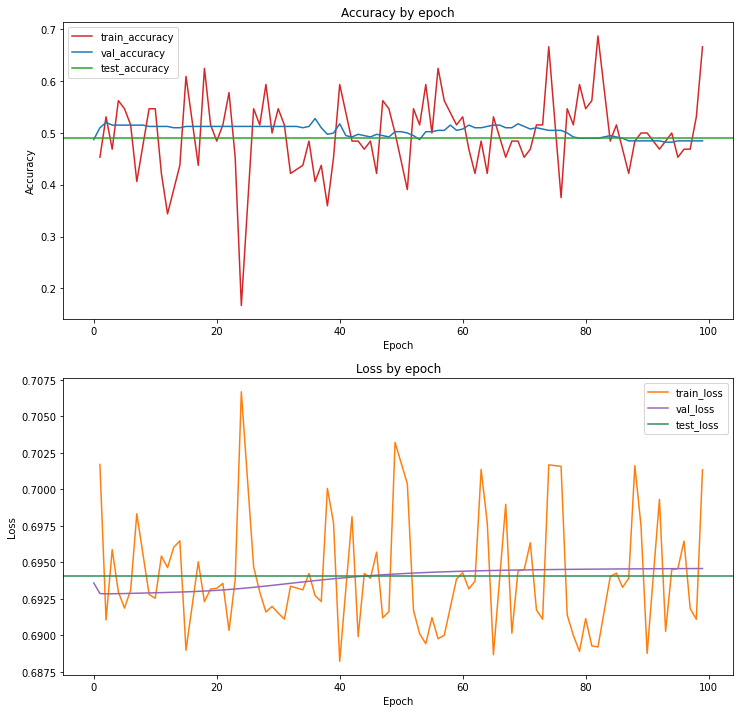

In [128]:
# plot
figs, axes = plt.subplots(nrows=2, figsize=(12, 12))

# accuracy
axes[0].plot(df_train['epoch'], df_train['train_accuracy'], color='tab:red', label='train_accuracy')
axes[0].plot(df_val['epoch'], df_val['val_accuracy'], color='tab:blue', label='val_accuracy')
axes[0].axhline(test_acc, color='tab:green', label='test_accuracy')

# loss
axes[1].plot(df_train['epoch'], df_train['train_loss'], color='tab:orange', label='train_loss')
axes[1].plot(df_val['epoch'], df_val['val_loss'], color='tab:purple', label='val_loss')
axes[1].axhline(test_loss, color='seagreen', label='test_loss')

# label, title, make pretty
titles = ['Accuracy by epoch', 'Loss by epoch']
dependent = ['Accuracy', 'Loss']
for i in range(2):
    axes[i].legend()
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel(dependent[i])
plt.show()